In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model

from PIL import Image as PILImage

import cv2
import numpy as np
import glob
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import Sequence

from keras.layers import Layer

import csv

In [9]:
IMAGE_SIZE = (256, 256)

In [25]:
def imshow(a, size=1.0):
    # Clip and convert the image to uint8
    a = a.clip(0, 255).astype("uint8")
    
    # Resize the image if a size factor is provided
    if size != 1.0:
        new_dim = (int(a.shape[1] * size), int(a.shape[0] * size))
        a = cv2.resize(a, new_dim, interpolation=cv2.INTER_AREA)
    

    # Display the image
    display(PILImage.fromarray(a))

In [11]:
class L2Normalization(Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=1)

In [12]:
model = load_model("embedding_resnet_model.keras",
    custom_objects={"L2Normalization": L2Normalization})

In [13]:
def read_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, IMAGE_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [23]:
import pandas as pd
import ast
from annoy import AnnoyIndex

embedding_dimensions = 128

#Annoy index for faster lookup with big dataset
index = AnnoyIndex(embedding_dimensions, "angular") #Consider using "euclidean" distance for L2 normalization

embeddings_df = pd.read_csv("embeddings.csv", header=None)

image_paths = embeddings_df[0].values
embeddings = embeddings_df[1].apply(ast.literal_eval).values

embeddings = np.array([np.array(embedding) for embedding in embeddings])

for i, embedding in enumerate(embeddings):
    index.add_item(i, embedding)

index.build(10)

True

Queries/003_0008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Queries/005_0087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Queries/009_0071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Queries/basketball_hoop.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Queries/bat.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


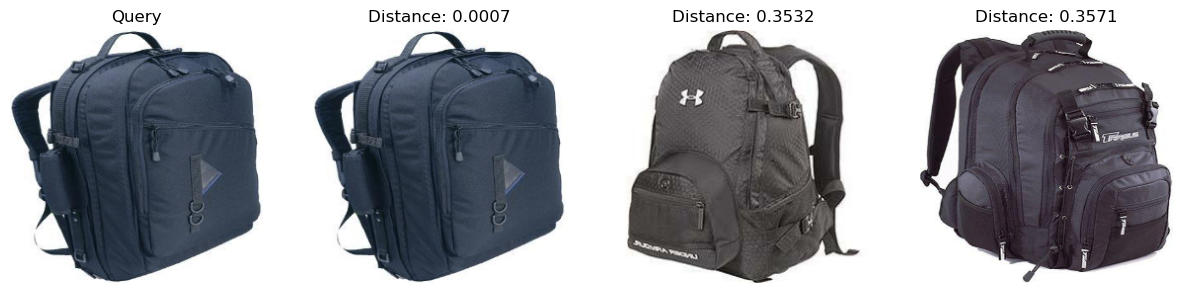

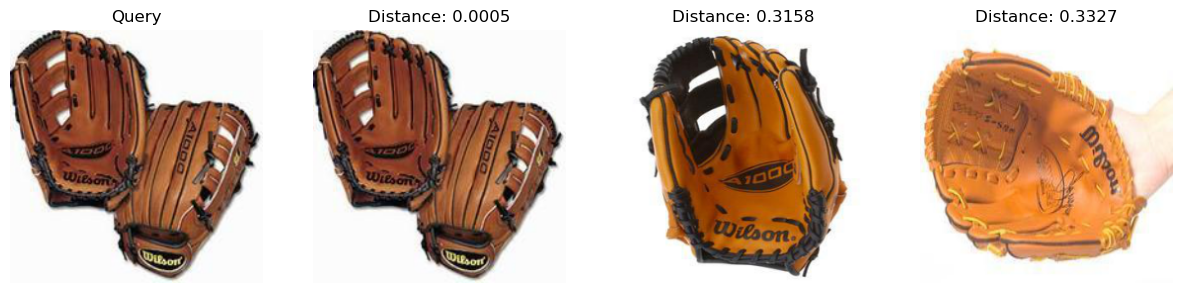

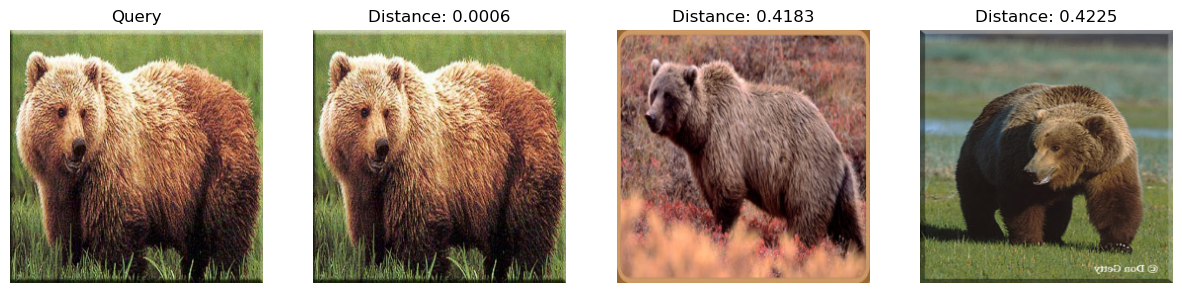

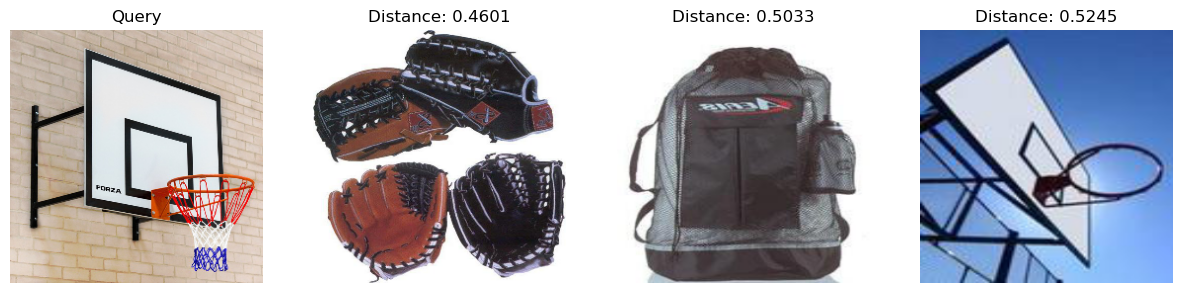

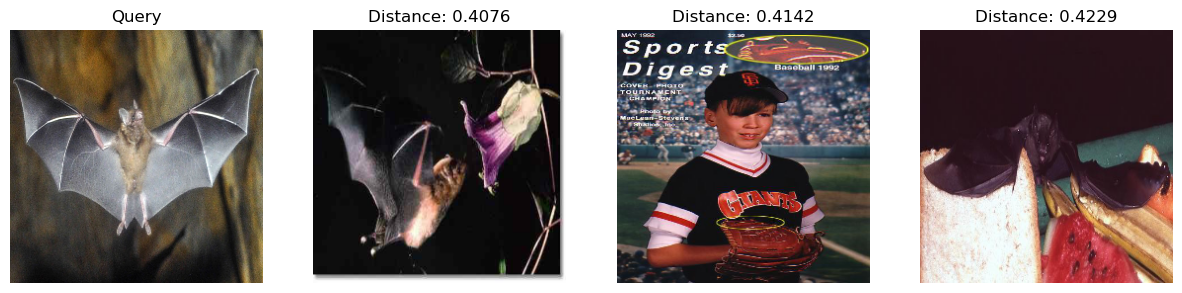

In [30]:
import matplotlib.pyplot as plt

query_folder = "Queries/*"
query_files = glob.glob(query_folder)

for query in query_files:
    print(query)
    img = read_image(query)
    embedding = model.predict(np.array([img]))[0]
    similar_image_indices, distances = index.get_nns_by_vector(embedding, 3, include_distances=True)

    match_1, match_2, match_3 = image_paths[similar_image_indices]
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    
    axes[0].imshow(img)
    axes[0].set_title("Query")
    axes[0].axis("off")
    
    axes[1].imshow(read_image(match_1))
    axes[1].set_title(f"Distance: {distances[0]:.4f}")
    axes[1].axis("off")
    
    axes[2].imshow(read_image(match_2))
    axes[2].set_title(f"Distance: {distances[1]:.4f}")
    axes[2].axis("off")
    
    axes[3].imshow(read_image(match_3))
    axes[3].set_title(f"Distance: {distances[2]:.4f}")
    axes[3].axis("off")
    
    